In [29]:
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn import svm
import numpy as np

# Set random seed
seed = 0

In [30]:
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')


In [31]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 735 entries, num__budget to category
dtypes: float64(734), object(1)
memory usage: 49.3+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

# Score prediction

In [32]:
X = df.drop('category', axis=1)
Y = df['category']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
Y_train_encoded = label_encoder.transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


## SVM

In [33]:
clf = svm.SVC(gamma='auto', kernel='linear')


clf.fit(X_train, Y_train_encoded)
Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6272054638588503


In [34]:
label_encoder.classes_

array(['bad', 'mediocre', 'good', 'great'], dtype='<U8')

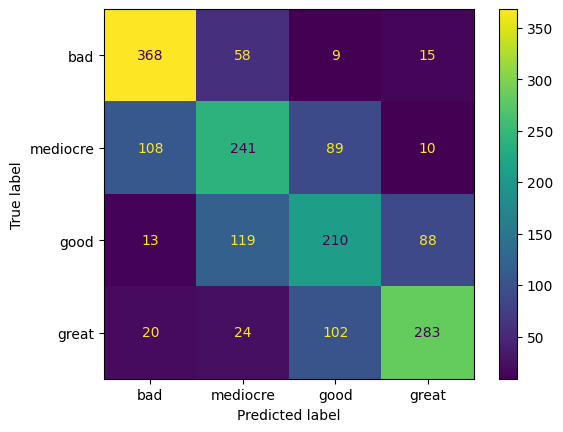

In [35]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

In [36]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print("Classification Report for SVM Model:")
print(classification_report(Y_test_encoded, Y_pred, target_names=label_encoder.classes_))


Classification Report for SVM Model:
              precision    recall  f1-score   support

         bad       0.72      0.82      0.77       450
    mediocre       0.55      0.54      0.54       448
        good       0.51      0.49      0.50       430
       great       0.71      0.66      0.69       429

    accuracy                           0.63      1757
   macro avg       0.62      0.63      0.62      1757
weighted avg       0.62      0.63      0.62      1757



In [37]:
all_feature_names = X.columns

In [38]:
from sklearn.tree import DecisionTreeClassifier, export_text


surrogate_model = DecisionTreeClassifier(max_depth=20) 
surrogate_model.fit(X_test, Y_pred)

# Print the rules
tree_rules = export_text(surrogate_model, feature_names=all_feature_names)
print(tree_rules)

|--- num__vote_count <= -0.40
|   |--- num__vote_count <= -0.51
|   |   |--- genres__documentary <= 0.50
|   |   |   |--- num__release_year <= -2.05
|   |   |   |   |--- num__vote_count <= -0.54
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- num__vote_count >  -0.54
|   |   |   |   |   |--- num__vote_count <= -0.53
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- num__vote_count >  -0.53
|   |   |   |   |   |   |--- overview__son <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- overview__son >  0.50
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |--- num__release_year >  -2.05
|   |   |   |   |--- num__runtime <= -0.16
|   |   |   |   |   |--- title__hell <= 0.50
|   |   |   |   |   |   |--- cast__johnhurt <= 0.50
|   |   |   |   |   |   |   |--- overview__save <= 0.66
|   |   |   |   |   |   |   |   |--- production_companies__raicinema <= 0.50
|   |   |   |   |   |   |   |   |   |--- cast__stephenroot <= 0.50
|   |   |   |   |

In [39]:
# Number of support vectors for each class
print("Number of Support Vectors for Each Class:", clf.n_support_)

# Total number of support vectors
print("Total Number of Support Vectors:", np.sum(clf.n_support_))

# Kernel computations (only relevant for non-linear kernels)
if clf.kernel != 'linear':
    print("Kernel Type:", clf.kernel)
    print("Number of Kernel Computations:", len(clf.support_vectors_) * len(X_train))


Number of Support Vectors for Each Class: [ 904 1437 1469  854]
Total Number of Support Vectors: 4664


In [40]:
if clf.kernel == 'linear':
    feature_importances = clf.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', key=abs, ascending=False)

    print("Top 10 Feature Importances for Linear SVM:")
    print(feature_importance_df.head(10))
else:
    print("Feature importance is only available for linear kernel SVMs.")


Top 10 Feature Importances for Linear SVM:
                                    Feature  Importance
4                           num__vote_count   -7.759844
703               directors__nightshyamalan    2.402081
455  production_companies__tsgentertainment    2.000000
641                            cast__reilly   -1.666928
384   production_companies__dcentertainment    1.655569
510             production_countries__india    1.567073
262                          tagline__crime   -1.538974
254                            tagline__big    1.497549
348                       genres__animation   -1.432816
663                       cast__willemdafoe    1.384274


In [41]:
# Use randm search to try to find best hyperparameters
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 10),
    'gamma': ['scale', 'auto']
}

#random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=seed, verbose=2, n_jobs=-1)
#random_search.fit(X_train, Y_train_encoded)

In [42]:
# Print best hyperparameters
best_params = {'C': 0.48425426472734723, 'degree': 5, 'gamma': 'scale', 'kernel': 'linear'}
best_model = svm.SVC(**best_params)
best_model.fit(X_train, Y_train_encoded)
#print("Best hyperparameters: ", random_search.best_params_)
#Best hyperparameters:  {'C': 0.48425426472734723, 'degree': 5, 'gamma': 'scale', 'kernel': 'linear'}

SVC(C=0.48425426472734723, degree=5, kernel='linear')

In [43]:
# Predict using best model
Y_pred = best_model.predict(X_test)
Y_pred_labels = label_encoder.inverse_transform(Y_pred)


In [44]:
accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6249288560045532
